# DATA SCIENCE SALARIES ANALYSIS

====================================================================
* objective
* frame business issue
* imperatives,
* performance measures
* tools and techniques to use

====================================================================
# Data Understanding
* Gather the data, 
* format, quantity, fields
* Explore data (querying/viz/reporting techniques)
* assess data quality (errors, missing data)

## Import Libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# To handle missing values
from feature_engine.imputation import AddMissingIndicator, CategoricalImputer

# To handle categorical features' cardinality
from feature_engine.encoding import RareLabelEncoder


pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 80)

## Gather the data
The data is available on [Kaggle](https://www.kaggle.com/datasets/jackogozaly/data-science-and-stem-salaries?select=Levels_Fyi_Salary_Data.csv) under a [CC0: Public Domain License](https://creativecommons.org/publicdomain/zero/1.0/). It contains 62,000 salary records from top companies.

In [2]:
# Loading raw data 
raw_data = pd.read_csv('Levels_Fyi_Salary_Data.csv')

# Dropping cols with unclear meaning & features that were created from categorical variables (race & education)
data = raw_data.drop(['dmaid', 'rowNumber', 'cityid', 'level', 'timestamp',
                      'Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic',
                     'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College'], axis=1)

# Checking data
print(data.shape)
data.head(3)

(62642, 14)


,company,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,Race,Education
0,Oracle,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,20000.0,10000.0,NaN,NaN,NaN,NaN
1,eBay,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,Amazon,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,0.0,0.0,NaN,NaN,NaN,NaN


## Assessing Data Quality

### Data Types

In [3]:
# Checking data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62642 entries, 0 to 62641
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  62637 non-null  object 
 1   title                    62642 non-null  object 
 2   totalyearlycompensation  62642 non-null  int64  
 3   location                 62642 non-null  object 
 4   yearsofexperience        62642 non-null  float64
 5   yearsatcompany           62642 non-null  float64
 6   tag                      61788 non-null  object 
 7   basesalary               62642 non-null  float64
 8   stockgrantvalue          62642 non-null  float64
 9   bonus                    62642 non-null  float64
 10  gender                   43102 non-null  object 
 11  otherdetails             40137 non-null  object 
 12  Race                     22427 non-null  object 
 13  Education                30370 non-null  object 
dtypes: float64(5), int64(1

### Missing values

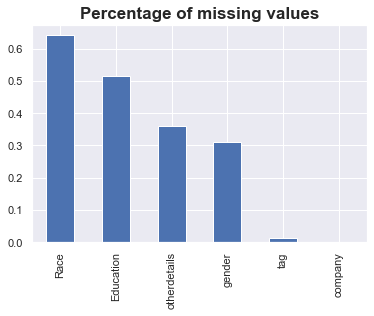

In [4]:
# Checking % of missing values      
cols_nan = [col for col in data if data[col].isna().sum() > 0]

data[cols_nan].isna().mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Percentage of missing values', weight='bold', size=17);

In [5]:
data.otherdetails.value_counts()

Masters                                                                                                               3983
Title: Software Engineer                                                                                              1453
Race: Asian, Academic Level: Master’s degree                                                                          1213
Race: White, Academic Level: Bachelor’s degree                                                                        1075
Race: Asian, Academic Level: Bachelor’s degree                                                                         977
                                                                                                                      ... 
Title: Robotics Systems Engineer, Race: White, Academic Level: Bachelor’s degree                                         1
Title: Senior Bios Engineer, Race: Asian, Academic Level: Bachelor’s degree                                              1
18k relocation b

In [6]:
data[data.Education == "Master's Degree"].otherdetails

5037                                                          Entry-level Masters Degree
7291                                                                       Masters in CS
12504                                                                            Masters
12506                                                                    Masters and PhD
12510                                                                            Masters
                                              ...                                       
61984     Remote, Title: Vp Of Engineering, Race: White, Academic Level: Master’s degree
61987    Title: Engineering Director, Facebook Ai, Race: Black or African American, A...
61988                            Title: Senior Director, Academic Level: Master’s degree
61991        Title: Senior Product Manager, Race: Asian, Academic Level: Master’s degree
62179                                    Title: Partner, Academic Level: Master’s degree
Name: otherdetails, L

In [7]:
# The "otherdetails" feature contains missing data & redundant data (e.g., includes education & race which are present in the data) so we can drop it
to_drop = ['otherdetails']
data = data.drop(to_drop, axis = 1)

cols_nan = [col for col in data if data[col].isna().sum() > 0]

#### Handling missing values
Only categorical features seem to have missing values. Moreover, some features have a very low % of missing values while others have much more missing data.

In [8]:
# Separating cols with high / low % of missing values
THRESHOLD = 0.02

low_nan = [col for col in cols_nan if data[col].isna().mean()<THRESHOLD]
high_nan = [col for col in cols_nan if col not in low_nan]

###### Low % of nan

In [9]:
# for columns with less than 2% of missing values we can probably drop the rows with missing values without missing too much data
data_less_nan = data.dropna(subset=low_nan)
diff = (len(data)-len(data_less_nan))/len(data)

print('Total number of obs:', data.shape[0])
print(f'Number of obs. after dropping missing values from {low_nan}:', len(data_less_nan))
print('Lost data: {0:.0%}'.format(diff))

Total number of obs: 62642
Number of obs. after dropping missing values from ['company', 'tag']: 61784
Lost data: 1%


In [10]:
data = data_less_nan.copy()

###### High % of nan

In [11]:
for col in high_nan:
    print(data[col].value_counts())
    print('=========================================\n')

Male                               35395
Female                              6957
Other                                398
Title: Senior Software Engineer        1
Name: gender, dtype: int64

Asian          11761
White           8028
Hispanic        1125
Two Or More      802
Black            690
Name: Race, dtype: int64

Master's Degree      15375
Bachelor's Degree    12587
PhD                   1701
Some College           355
Highschool             320
Name: Education, dtype: int64



First we can see that there is an error in the data, on the Gender feature:

In [12]:
data[data.gender == 'Title: Senior Software Engineer']

,company,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,Race,Education
11010,GitHub,Software Engineer,205000,"Buda, TX",15.0,4.0,Distributed Systems (Back-End),177000.0,31000.0,1000.0,Title: Senior Software Engineer,NaN,NaN


In [13]:
# Fixing the error
data.loc[11010,'gender'] = np.nan
data.gender.value_counts()

Male      35395
Female     6957
Other       398
Name: gender, dtype: int64

In [14]:
# Now we can fill the missing values with the most frequent value, but keeping track of which values are missing
# Add missing indicator
# miss_ind = AddMissingIndicator(variables=high_nan)
# data = miss_ind.fit_transform(data)

# categorical imputer
cat_imp = CategoricalImputer(imputation_method='missing', 
                             fill_value='Unknown',
                             variables=high_nan)
data = cat_imp.fit_transform(data)

In [15]:
data.isna().sum()

company                    0
title                      0
totalyearlycompensation    0
location                   0
yearsofexperience          0
yearsatcompany             0
tag                        0
basesalary                 0
stockgrantvalue            0
bonus                      0
gender                     0
Race                       0
Education                  0
dtype: int64

====================================================================
# Data Preparation

## Handling Categorical Features

## Locations

In [16]:
data.location.str.split(',', 1, expand=True)[1].value_counts()

 CA                      22426
 WA                      12023
 NY                       4677
 TX                       2692
 MA                       1731
                         ...  
 GU, Guatemala               1
 MY, Ukraine                 1
 VC, Colombia                1
 MH, Marshall Islands        1
 KY, Japan                   1
Name: 1, Length: 266, dtype: int64

In [17]:
#getting countries, idea and code from https://www.kaggle.com/code/carlosfg97/stem-salaries-prediction-15-mape
data['country'] = data.location.str.split(',').apply(lambda x:x[-1][1:])
data.loc[data.country.str.len() == 2,'country'] = 'US'
data.country.value_counts().head(6)

US                52019
India              2828
Canada             1788
United Kingdom     1185
Germany             576
Singapore           371
Name: country, dtype: int64

In [18]:
data = data.drop(['location'], axis = 1)

### Rare Labels

In [19]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
data[cat_vars].head(3)

,company,title,tag,gender,Race,Education,country
409,Yahoo,Software Engineer,Full Stack,Male,Unknown,Unknown,US
410,Oracle,Software Engineering Manager,Distributed Systems (Back-End),Male,Unknown,Unknown,US
411,Qualcomm,Software Engineer,Embedded Systems,Male,Unknown,Unknown,US


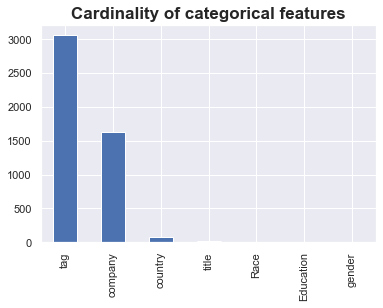

In [20]:
data[cat_vars].nunique().sort_values(ascending = False).plot(kind='bar')
plt.title('Cardinality of categorical features', weight='bold', size=17);

In [21]:
high_card = [var for var in cat_vars if data[var].nunique() > 10]

In [22]:
rare_encoder = RareLabelEncoder(tol = 0.01, 
                                variables = high_card,
                                replace_with = 'Other (1%)')

data = rare_encoder.fit_transform(data)

In [23]:
colors = ['#1780a1', '#065a60', '#212f45', '#312244', '#4d194d', '#a01a58']

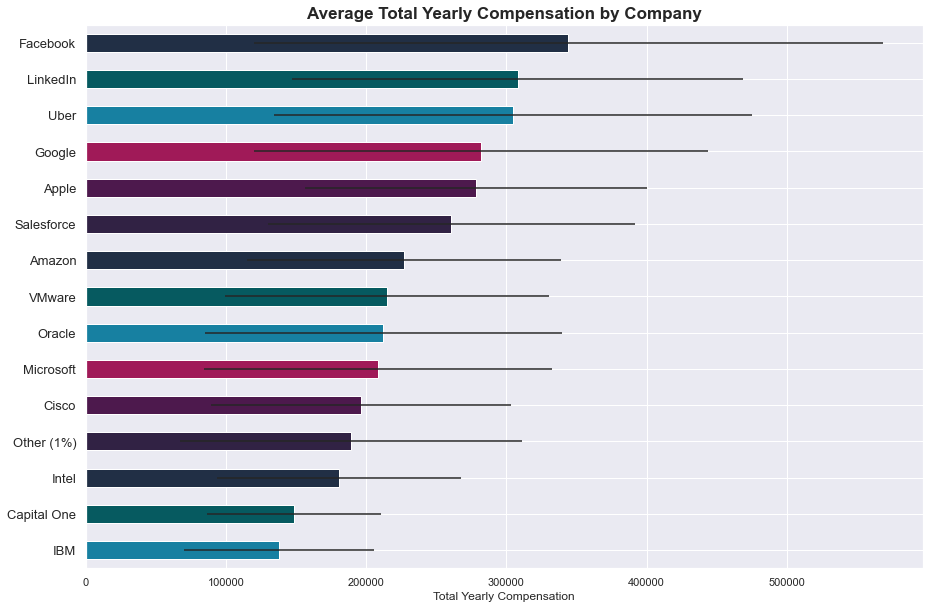

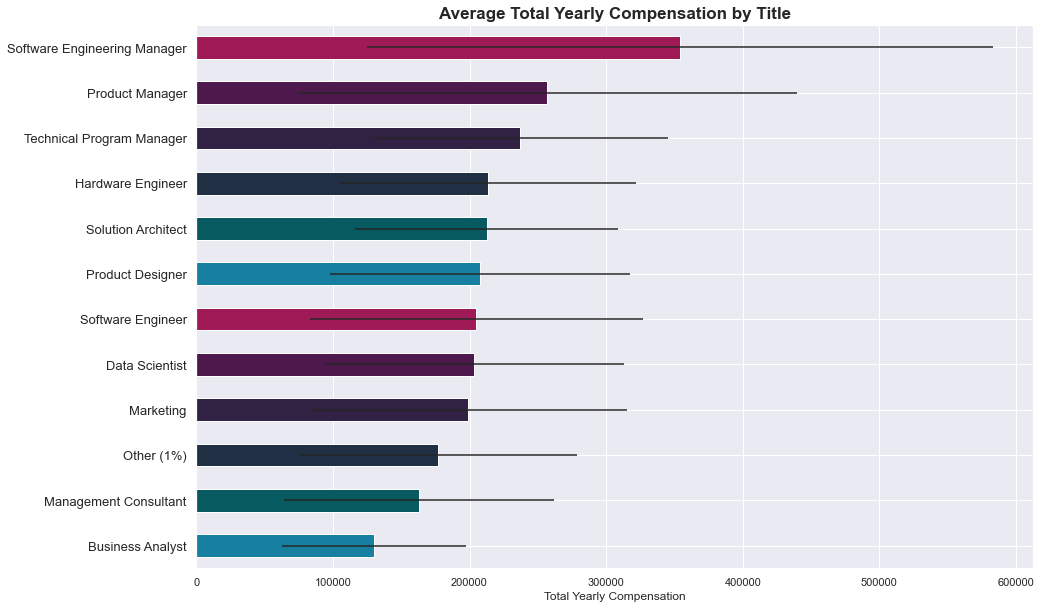

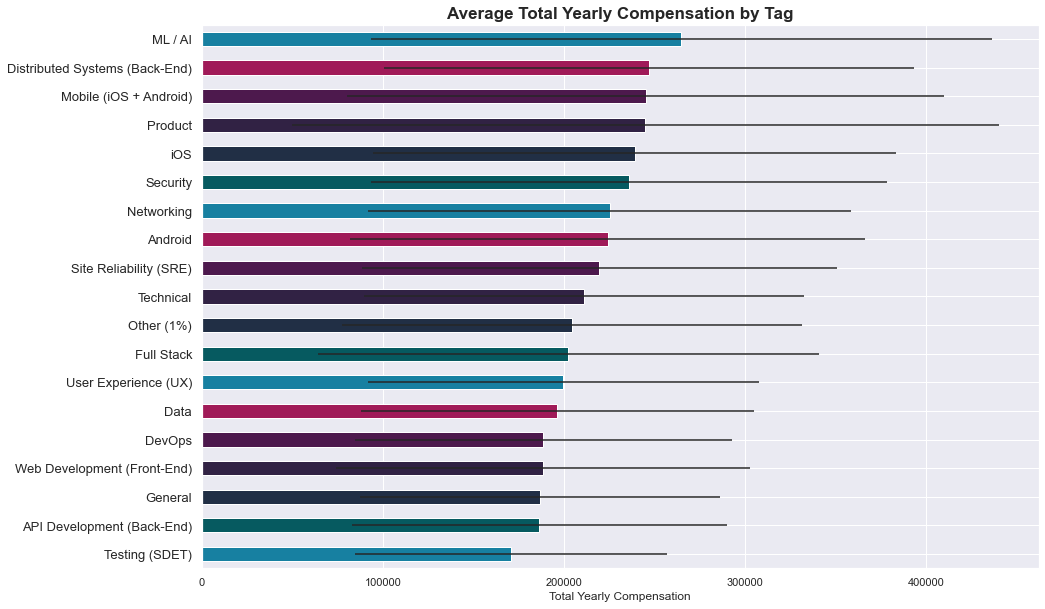

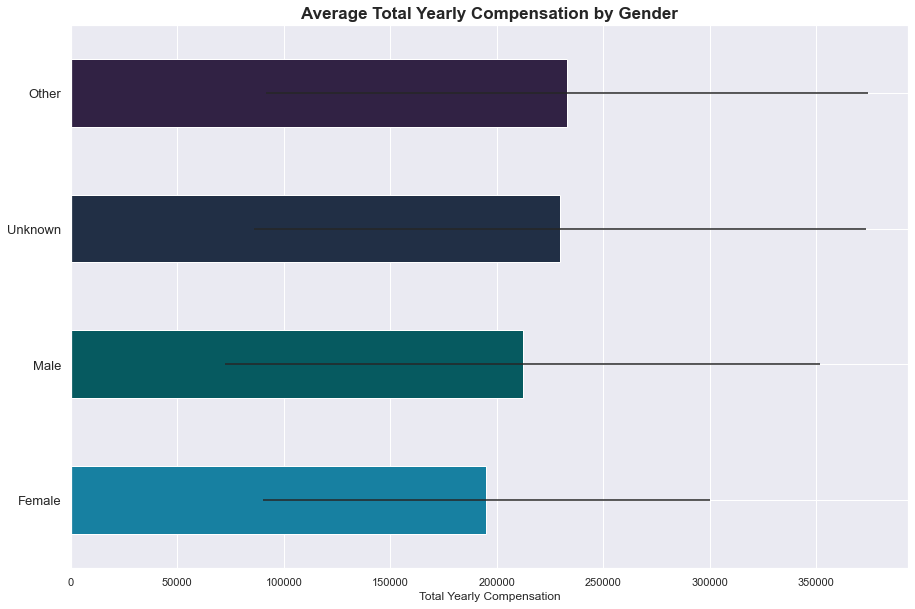

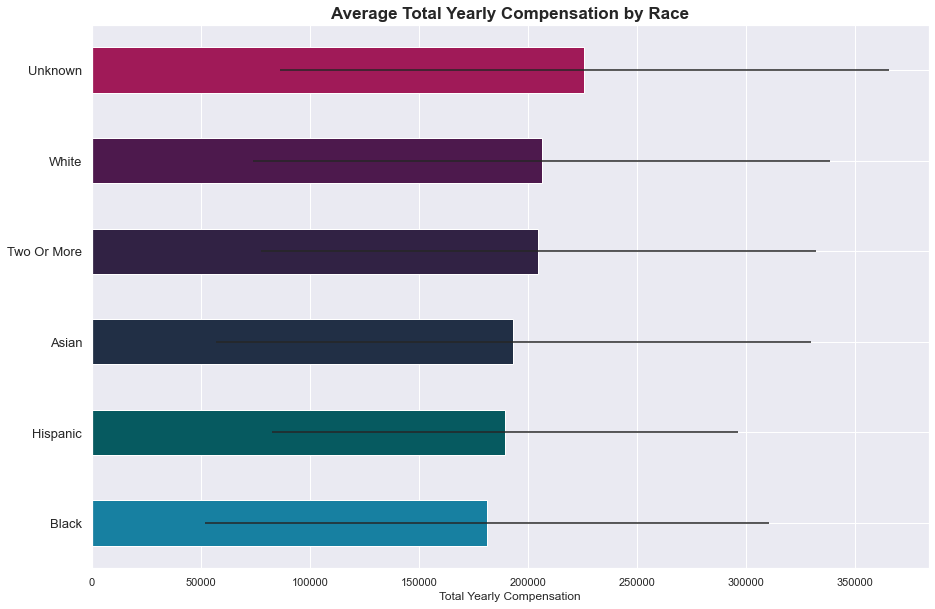

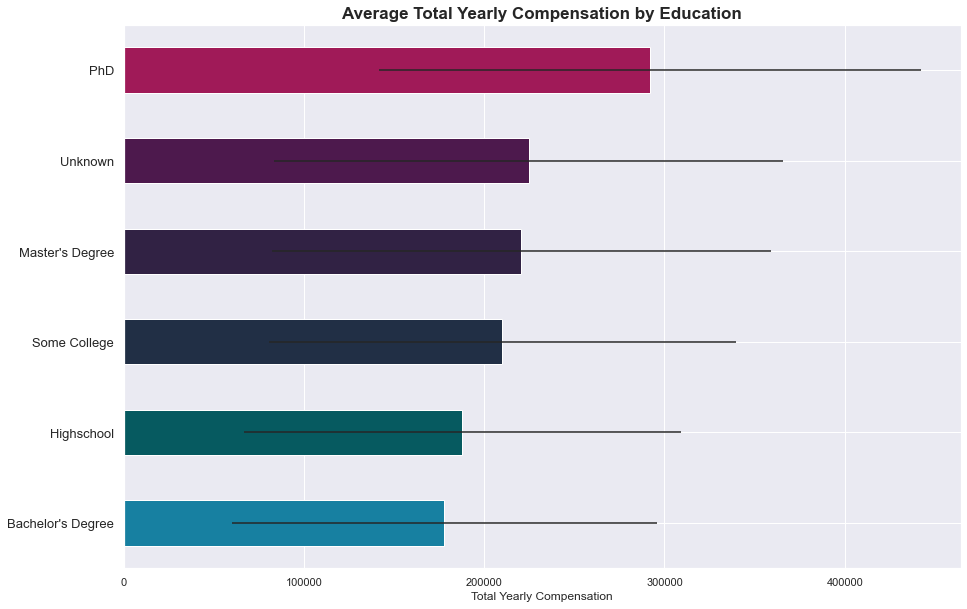

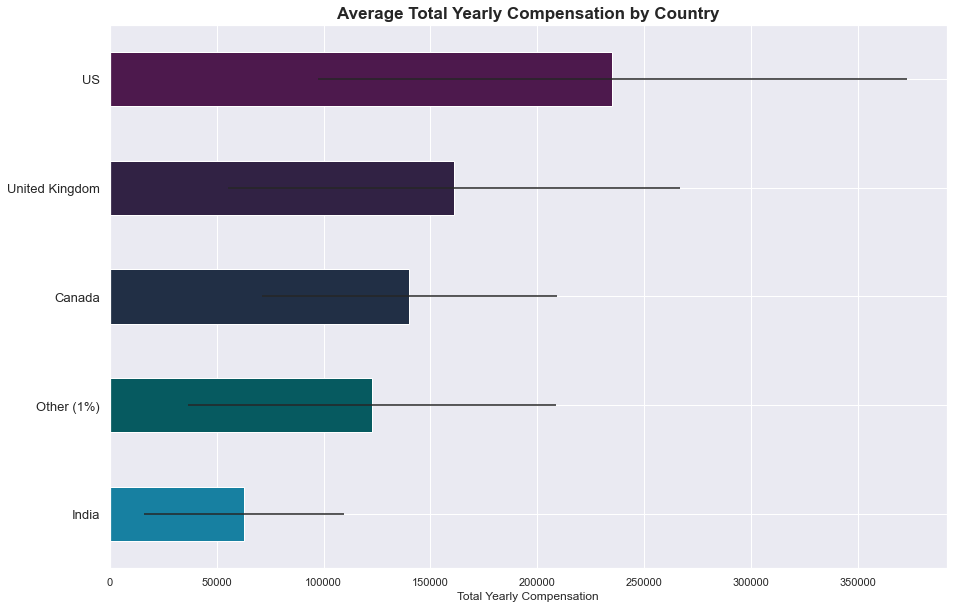

In [24]:
for var in data[cat_vars]:
    # get mean & std compensation for each categorical variable
    tmp = data.groupby(var)['totalyearlycompensation'].agg(['mean', 'std'])

    # plot into a bar graph
    tmp.sort_values(by='mean').plot(kind="barh", y="mean", legend=False,
                 xerr="std", title="Price", color=colors, figsize=(15,10))
    
    plt.title(f'Average Total Yearly Compensation by {var.capitalize()}', weight='bold', size=17)
    plt.xlabel('Total Yearly Compensation')
    plt.yticks(size=13)
    plt.ylabel('')
    plt.show() 

### Encoding categorical features

In [121]:
df = data.copy()

In [122]:
# Get avg annual total salary for each title
avg_salary_title = df.groupby('title').mean()['totalyearlycompensation'].to_dict()

# Then cast "title" with this value:
df['title'] = df['title'].replace(avg_salary_title)
df = df.rename({'title':'AVGsalaryTitle'})
# high_card.remove('title')
df.head()

,company,title,totalyearlycompensation,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,Race,Education,country
409,Other (1%),204855.441372,160500,0.58,0.58,Full Stack,128000.0,13000.0,19200.0,Male,Unknown,Unknown,US
410,Oracle,354343.847684,340000,16.00,15.00,Distributed Systems (Back-End),206000.0,134000.0,0.0,Male,Unknown,Unknown,US
411,Other (1%),204855.441372,240000,15.00,6.00,Other (1%),0.0,0.0,0.0,Male,Unknown,Unknown,US
412,Other (1%),204855.441372,160000,5.00,3.00,Full Stack,0.0,0.0,0.0,Male,Unknown,Unknown,US
413,Google,204855.441372,208000,0.00,0.00,Distributed Systems (Back-End),116000.0,65000.0,17000.0,Male,Unknown,Unknown,US


In [123]:
from feature_engine.encoding import CountFrequencyEncoder

count_enc = CountFrequencyEncoder(encoding_method='frequency', variables=high_card)
df_enc = count_enc.fit_transform(df)


print(df_enc.shape)
df_enc.head(3)

(61784, 13)


,company,title,totalyearlycompensation,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,Race,Education,country
409,0.513531,204855.441372,160500,0.58,0.58,0.184206,128000.0,13000.0,19200.0,Male,Unknown,Unknown,0.841949
410,0.018031,354343.847684,340000,16.00,15.00,0.175401,206000.0,134000.0,0.0,Male,Unknown,Unknown,0.841949
411,0.513531,204855.441372,240000,15.00,6.00,0.194435,0.0,0.0,0.0,Male,Unknown,Unknown,0.841949


In [124]:
df_ohe = pd.get_dummies(df_enc)
print(df_ohe.shape)
df_ohe.head(3)

(61784, 26)


,company,title,totalyearlycompensation,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,country,gender_Female,gender_Male,gender_Other,gender_Unknown,Race_Asian,Race_Black,Race_Hispanic,Race_Two Or More,Race_Unknown,Race_White,Education_Bachelor's Degree,Education_Highschool,Education_Master's Degree,Education_PhD,Education_Some College,Education_Unknown
409,0.513531,204855.441372,160500,0.58,0.58,0.184206,128000.0,13000.0,19200.0,0.841949,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
410,0.018031,354343.847684,340000,16.00,15.00,0.175401,206000.0,134000.0,0.0,0.841949,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
411,0.513531,204855.441372,240000,15.00,6.00,0.194435,0.0,0.0,0.0,0.841949,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


## Model

In [125]:
df_final = df_ohe.drop(['stockgrantvalue','bonus','basesalary'], axis=1) 

In [126]:
X = df_final.drop('totalyearlycompensation', axis=1)
y = df_final.totalyearlycompensation

In [127]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [128]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, random_state=42, 
                              max_features=8, max_depth=10)


model.fit(X_train, y_train) 
model.score(X_test, y_test)

0.4943590302144494

In [ ]:
model.score(X_train, y_train)